In [2]:
import numpy as np
import matplotlib.pyplot as plt
from spacepy import pycdf
import datetime
import math
from scipy import signal

## Observations

In [3]:
#reading cdf file in downloaded from cdaweb, WIND/3DP stallite data
filename=('wi_sfsps_3dp_20020414222510_20020414234958.cdf')
cdf = pycdf.CDF(filename)
energies=cdf['ENERGY'][1]

#Reading the date of the observation
year=cdf['Epoch'][1].year
month=cdf['Epoch'][1].month
day=cdf['Epoch'][1].day

#Setting the approximate time of injection
hour=22
minute=25

In [4]:
#Calculating the velocity and time travelled from the energies of the electrons

#Setting some constants
erest_energy=511000 # rest energy of an electron in eV
c=3*(10**8) #light speed
L_0=15 #sun-earth distance in 10**10 m, working in this unit as working in meters results in overflow

#Relativistic calculation:
gamma=np.zeros(len(energies))
v_rel=np.zeros(len(energies))
t_rel=np.zeros(len(energies))
t_rel_s=np.zeros(len(energies))
for i in range(len(energies)):
    gamma[i]=energies[i]/erest_energy+1 #calculating the Lorentz factor
    v_rel[i]=c*np.sqrt(1-1/(np.square(gamma[i])))*10**(-10) #calculating the velocity corresponding to each energy, changing the units to 10**10 m
    t_rel[i]=(L_0/v_rel[i])/60 #calculating the time travelled by the electron in minutes
    t_rel_s[i]=(L_0/v_rel[i]) #and in seconds
print(v_rel) #in 10**10 m/s

[0.00938363 0.01123912 0.0139477  0.01695672 0.02025697 0.02347181
 0.02602964]


## Model

In [5]:
#calculation of the diffusion coefficient for the observed energy channels
#take a first approximation mfp
mfp1=10**(3) #an initial value for the mean free path, the units are 10**10 m, as working with the values in m results in overflow
mfp2=10**(2)
mfp3=10
mfp4=5
mfp0=0
D1=np.zeros(len(energies))
D2=np.zeros(len(energies))
D3=np.zeros(len(energies))
D4=np.zeros(len(energies))
for i in range(len(energies)):
    D1[i]=(mfp1*v_rel[i])/3 #spatial diffusion coefficient
    D2[i]=(mfp2*v_rel[i])/3
    D3[i]=(mfp3*v_rel[i])/3
    D4[i]=(mfp4*v_rel[i])/3

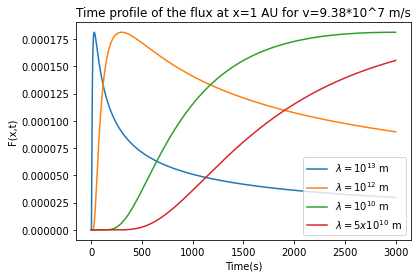

In [6]:
#plotting the simple diffusion solution for a few mean free path values
#we can see that the delay gets larger with decreasing mean free path values

x=15 # 1 AU
t=np.arange(1,3000) #time passed since injection
n_0=1 #setting the initial number density to be 1, this could be anything
n1=np.zeros((len(t),len(energies))) #the rows are various times, the columns are various energies
F1=np.zeros((len(t),len(energies)))
n2=np.zeros((len(t),len(energies)))
F2=np.zeros((len(t),len(energies)))
n3=np.zeros((len(t),len(energies))) 
F3=np.zeros((len(t),len(energies)))
n4=np.zeros((len(t),len(energies))) 
F4=np.zeros((len(t),len(energies)))
for i in range(len(energies)):
    n1[:,i]=np.sqrt(1/(4*np.pi*D1[i]*t))*n_0*np.exp(-(np.square(x)/(4*D1[i]*t))) #the number density
    F1[:,i]=v_rel[i]*n1[:,i] #the number flux
    n2[:,i]=np.sqrt(1/(4*np.pi*D2[i]*t))*n_0*np.exp(-(np.square(x)/(4*D2[i]*t))) #the number density
    F2[:,i]=v_rel[i]*n2[:,i] #the number flux
    n3[:,i]=np.sqrt(1/(4*np.pi*D3[i]*t))*n_0*np.exp(-(np.square(x)/(4*D3[i]*t))) #the number density
    F3[:,i]=v_rel[i]*n3[:,i] #the number flux
    n4[:,i]=np.sqrt(1/(4*np.pi*D4[i]*t))*n_0*np.exp(-(np.square(x)/(4*D4[i]*t))) #the number density
    F4[:,i]=v_rel[i]*n4[:,i] #the number flux
    
#only plotting the first energy channel as we only want to see the tendency when changing the mean free path
plt.plot(t,F1[:,1], label='$\lambda=10^{13}$ m')
plt.plot(t,F2[:,1], label='$\lambda=10^{12}$ m')
plt.plot(t,F3[:,1], label='$\lambda=10^{10}$ m')
plt.plot(t,F4[:,1], label='$\lambda=5x10^{10}$ m')
plt.title('Time profile of the flux at x=1 AU for v=9.38*10^7 m/s')
plt.xlabel('Time(s)')
plt.ylabel('F(x,t)')
plt.legend()

## Observations vs. Model

In [7]:
#need to change the t vector to match the observation time vector
min_len=85 #85 minutes in total
sec_len=min_len*60
bin_len=sec_len/len(cdf['Epoch']) #how large is a bin?
t_comp=np.arange(0, sec_len, bin_len) #the time vector to use for the comparison

In [8]:
#typing in the equation
#setting the mean free path values that we are interested in

F_comp1=np.zeros((len(t_comp),len(energies))) 
F_comp2=np.zeros((len(t_comp),len(energies))) 
F_comp3=np.zeros((len(t_comp),len(energies))) 
F_comp4=np.zeros((len(t_comp),len(energies))) 
D_fit1=np.zeros(len(energies))
D_fit2=np.zeros(len(energies))
D_fit3=np.zeros(len(energies))
D_fit4=np.zeros(len(energies))
#the mean free path values, in the range between 1 and 10
mfp_fit1=2.5
mfp_fit2=4.5
mfp_fit3=6.5
mfp_fit4=8.5
for i in range(len(energies)):
    D_fit1[i]=v_rel[i]*mfp_fit1/3
    D_fit2[i]=v_rel[i]*mfp_fit2/3
    D_fit3[i]=v_rel[i]*mfp_fit3/3
    D_fit4[i]=v_rel[i]*mfp_fit4/3
for i in range(len(energies)):
    F_comp1[:,i]=v_rel[i]*np.sqrt(1/(4*np.pi*D_fit1[i]*t_comp))*n_0*np.exp(-(np.square(x)/(4*D_fit1[i]*t_comp)))
    F_comp2[:,i]=v_rel[i]*np.sqrt(1/(4*np.pi*D_fit2[i]*t_comp))*n_0*np.exp(-(np.square(x)/(4*D_fit2[i]*t_comp)))
    F_comp3[:,i]=v_rel[i]*np.sqrt(1/(4*np.pi*D_fit3[i]*t_comp))*n_0*np.exp(-(np.square(x)/(4*D_fit3[i]*t_comp)))
    F_comp4[:,i]=v_rel[i]*np.sqrt(1/(4*np.pi*D_fit4[i]*t_comp))*n_0*np.exp(-(np.square(x)/(4*D_fit4[i]*t_comp)))

    #the warning appears cause the first item in the time vector is 0. not a problem

<ipython-input-8-cb85cd91061a>:23: RuntimeWarning: divide by zero encountered in true_divide
  F_comp1[:,i]=v_rel[i]*np.sqrt(1/(4*np.pi*D_fit1[i]*t_comp))*n_0*np.exp(-(np.square(x)/(4*D_fit1[i]*t_comp)))
<ipython-input-8-cb85cd91061a>:23: RuntimeWarning: invalid value encountered in multiply
  F_comp1[:,i]=v_rel[i]*np.sqrt(1/(4*np.pi*D_fit1[i]*t_comp))*n_0*np.exp(-(np.square(x)/(4*D_fit1[i]*t_comp)))
<ipython-input-8-cb85cd91061a>:24: RuntimeWarning: divide by zero encountered in true_divide
  F_comp2[:,i]=v_rel[i]*np.sqrt(1/(4*np.pi*D_fit2[i]*t_comp))*n_0*np.exp(-(np.square(x)/(4*D_fit2[i]*t_comp)))
<ipython-input-8-cb85cd91061a>:24: RuntimeWarning: invalid value encountered in multiply
  F_comp2[:,i]=v_rel[i]*np.sqrt(1/(4*np.pi*D_fit2[i]*t_comp))*n_0*np.exp(-(np.square(x)/(4*D_fit2[i]*t_comp)))
<ipython-input-8-cb85cd91061a>:25: RuntimeWarning: divide by zero encountered in true_divide
  F_comp3[:,i]=v_rel[i]*np.sqrt(1/(4*np.pi*D_fit3[i]*t_comp))*n_0*np.exp(-(np.square(x)/(4*D_fit3[i

In [9]:
#need to substract the background
#this is a simplified methods, could be fine tuned
cdf_bgcorr=np.zeros((len(t_comp),len(energies)))
for i in range(len(energies)):
    cdf_bgcorr[:,i]=cdf['FLUX'][:,i]-np.average(cdf['FLUX'][1:25,i])
print(np.average(cdf['FLUX'][1:25,1]))

0.0025245023


In [10]:
#getting rid of the NaN values
nonan_F_comp1=np.nan_to_num(F_comp1)
nonan_F_comp2=np.nan_to_num(F_comp2)
nonan_F_comp3=np.nan_to_num(F_comp3)
nonan_F_comp4=np.nan_to_num(F_comp4)
nonan_cdf=np.nan_to_num(cdf_bgcorr,neginf=0.0) #observed data

#normalizing the observed data
norm_flux=np.zeros((len(t_comp),len(energies)))
norm_mod1=np.zeros((len(t_comp),len(energies)))
norm_mod2=np.zeros((len(t_comp),len(energies)))
norm_mod3=np.zeros((len(t_comp),len(energies)))
norm_mod4=np.zeros((len(t_comp),len(energies)))
for i in range(len(energies)):
    norm_flux[:,i]=(nonan_cdf[:,i]-np.amin(nonan_cdf[:,i]))/(np.amax(nonan_cdf[:,i])-np.amin(nonan_cdf[:,i]))
    norm_mod1[:,i]=(nonan_F_comp1[:,i]-np.amin(nonan_F_comp1[:,i]))/(np.amax(nonan_F_comp1[:,i])-np.amin(nonan_F_comp1[:,i]))
    norm_mod2[:,i]=(nonan_F_comp2[:,i]-np.amin(nonan_F_comp2[:,i]))/(np.amax(nonan_F_comp2[:,i])-np.amin(nonan_F_comp2[:,i]))
    norm_mod3[:,i]=(nonan_F_comp3[:,i]-np.amin(nonan_F_comp3[:,i]))/(np.amax(nonan_F_comp3[:,i])-np.amin(nonan_F_comp3[:,i]))
    norm_mod4[:,i]=(nonan_F_comp4[:,i]-np.amin(nonan_F_comp4[:,i]))/(np.amax(nonan_F_comp4[:,i])-np.amin(nonan_F_comp4[:,i]))

Text(0.5, 0, 'Time after injection (s)')

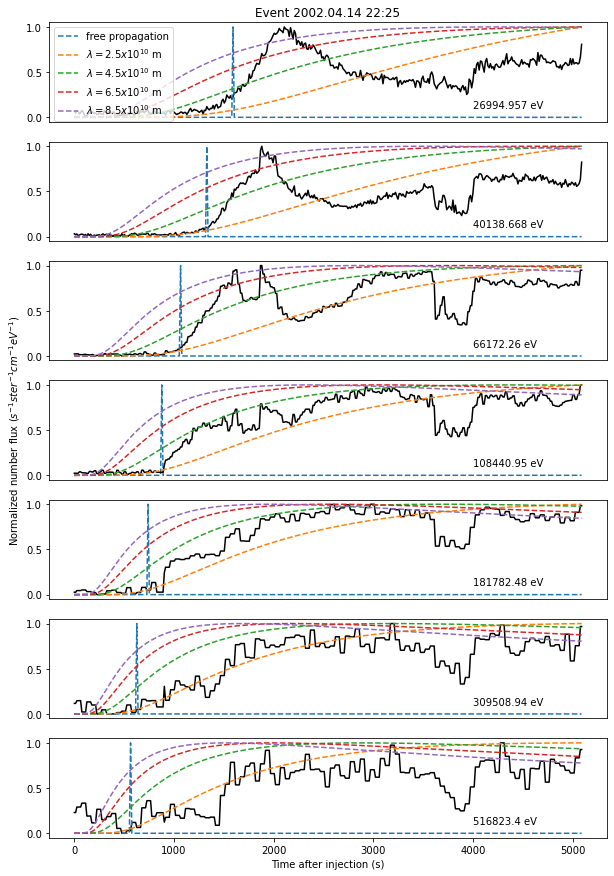

In [11]:
#not plotting the data

plt.figure(figsize=(10,15))

plt.subplot(711)
plt.plot(t_comp,norm_flux[:,0],'black') #the observations
imp1 = signal.unit_impulse(len(t_comp), int(t_rel_s[0]/bin_len))
plt.plot(t_comp,imp1,'--',label='free propagation') #unit impulse that we would see if the electrons would propagate freely
plt.plot(t_comp,norm_mod1[:,0],'--',label='$\lambda=2.5x10^{10}$ m') #the models
plt.plot(t_comp,norm_mod2[:,0],'--',label='$\lambda=4.5x10^{10}$ m')
plt.plot(t_comp,norm_mod3[:,0],'--',label='$\lambda=6.5x10^{10}$ m')
plt.plot(t_comp,norm_mod4[:,0],'--',label='$\lambda=8.5x10^{10}$ m')
plt.legend(loc='upper left')
plt.text(4000,0.1,str(energies[0])+' eV') #printing the energy channel
plt.title('Event 2002.04.14 22:25') #setting the title
plt.xticks([]) #hiding the ticks on the x axis

plt.subplot(712)
plt.plot(t_comp,norm_flux[:,1],'black')
imp2 = signal.unit_impulse(len(t_comp), int(t_rel_s[1]/bin_len))
plt.plot(t_comp,imp2,'--')
plt.plot(t_comp,norm_mod1[:,1],'--')
plt.plot(t_comp,norm_mod2[:,1],'--')
plt.plot(t_comp,norm_mod3[:,1],'--')
plt.plot(t_comp,norm_mod4[:,1],'--')
plt.text(4000,0.1,str(energies[1])+' eV')
plt.xticks([])

plt.subplot(713)
plt.plot(t_comp,norm_flux[:,2],'black')
imp3 = signal.unit_impulse(len(t_comp), int(t_rel_s[2]/bin_len))
plt.plot(t_comp,imp3,'--')
plt.plot(t_comp,norm_mod1[:,2],'--')
plt.plot(t_comp,norm_mod2[:,2],'--')
plt.plot(t_comp,norm_mod3[:,2],'--')
plt.plot(t_comp,norm_mod4[:,2],'--')
plt.text(4000,0.1,str(energies[2])+' eV')
plt.xticks([])

plt.subplot(714)
imp4 = signal.unit_impulse(len(t_comp), int(t_rel_s[3]/bin_len))
plt.plot(t_comp,imp4,'--')
plt.plot(t_comp,norm_flux[:,3],'black')
plt.plot(t_comp,norm_mod1[:,3],'--')
plt.plot(t_comp,norm_mod2[:,3],'--')
plt.plot(t_comp,norm_mod3[:,3],'--')
plt.plot(t_comp,norm_mod4[:,3],'--')
plt.text(4000,0.1,str(energies[3])+' eV')
plt.ylabel('Normalized number flux ($s^{-1}ster^{-1}cm^{-1}eV^{-1}$)')
plt.xticks([])

plt.subplot(715)
plt.plot(t_comp,norm_flux[:,4],'black')
imp5 = signal.unit_impulse(len(t_comp), int(t_rel_s[4]/bin_len))
plt.plot(t_comp,imp5,'--')
plt.plot(t_comp,norm_mod1[:,4],'--')
plt.plot(t_comp,norm_mod2[:,4],'--')
plt.plot(t_comp,norm_mod3[:,4],'--')
plt.plot(t_comp,norm_mod4[:,4],'--')
plt.text(4000,0.1,str(energies[4])+' eV')
plt.xticks([])

plt.subplot(716)
plt.plot(t_comp,norm_flux[:,5],'black')
imp6 = signal.unit_impulse(len(t_comp), int(t_rel_s[5]/bin_len))
plt.plot(t_comp,imp6,'--')
plt.plot(t_comp,norm_mod1[:,5],'--')
plt.plot(t_comp,norm_mod2[:,5],'--')
plt.plot(t_comp,norm_mod3[:,5],'--')
plt.plot(t_comp,norm_mod4[:,5],'--')
plt.text(4000,0.1,str(energies[5])+' eV')
plt.xticks([])

plt.subplot(717)
plt.plot(t_comp,norm_flux[:,6],'black')
imp7 = signal.unit_impulse(len(t_comp), int(t_rel_s[6]/bin_len))
plt.plot(t_comp,imp7,'--')
plt.plot(t_comp,norm_mod1[:,6],'--')
plt.plot(t_comp,norm_mod2[:,6],'--')
plt.plot(t_comp,norm_mod3[:,6],'--')
plt.plot(t_comp,norm_mod4[:,6],'--')
plt.text(4000,0.1,str(energies[6])+' eV')
plt.xlabel('Time after injection (s)')


## Is it fair to assume that $x_0$ is much smaller than $x$?

In [12]:
#take x_0 to be the solar radius, this is just a rough approximation
x_0=7*10**(-2) #in 10**10 m
n_approx=np.zeros((len(t),len(energies)))
n_wx_0=np.zeros((len(t),len(energies)))
#comparing for mfp=10**(-7)
for i in range(len(energies)):
    n_approx[:,i]=np.sqrt(1/(4*np.pi*D1[i]*t))*n_0*np.exp(-(np.square(x)/(4*D1[i]*t)))
    n_wx_0[:,i]=np.sqrt(1/(4*np.pi*D1[i]*t))*n_0*np.exp(-(np.square(x-x_0)/(4*D1[i]*t)))
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

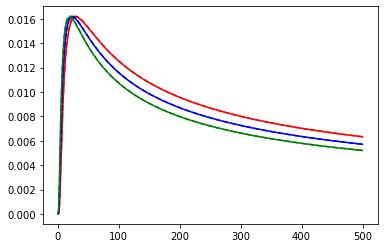

In [13]:
plt.plot(t[0:500],n_approx[0:500,1],'r')
plt.plot(t[0:500],n_approx[0:500,2],'b')
plt.plot(t[0:500],n_approx[0:500,3],'g')
plt.plot(t[0:500],n_wx_0[0:500,1],'r--')
plt.plot(t[0:500],n_wx_0[0:500,2],'b--')
plt.plot(t[0:500],n_wx_0[0:500,3],'g--')

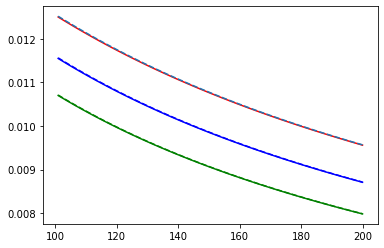

In [14]:
#zooming in
plt.plot(t[100:200],n_approx[100:200,1],'r')
plt.plot(t[100:200],n_approx[100:200,2],'b')
plt.plot(t[100:200],n_approx[100:200,3],'g')
plt.plot(t[100:200],n_wx_0[100:200,1],'--')
plt.plot(t[100:200],n_wx_0[100:200,2],'b--')
plt.plot(t[100:200],n_wx_0[100:200,3],'g--')

#it doesn't make a difference